### ScienceSage RAG LLM Evaluation Metrics

This notebook computes and visualizes key retrieval metrics for the RAG pipeline:

- **Precision@k** e.g., Precision@5): 
  - How many retrieved sources were actually relevant. 
  - Formula: Precision@k = (Number of relevant items in top k) / k

- **Recall@k** (e.g., Recall@5): 
  - How often the correct source was retrieved in the top k retrieved results. 
  - Formula: Recall@k = (Number of relevant items in top k) / (Total number of relevant items)

- **Mean Reciprocal Rank (MRR)**: 
  - Measures how soon the first relevant result appears in the ranked list of retrieved items. It is the average of the reciprocal ranks of the first relevant answer for a set of queries.  
  - Higher MRR means relevant answers are found closer to the top of the results. 
  - Formula: MRR = (1 / rank of first relevant result), averaged over all queries.

- **Normalized Discounted Cumulative Gain (nDCG)**: 
  - Evaluates the quality of the ranking by considering the position of relevant results, giving higher scores to relevant items appearing earlier. It is normalized so that a perfect ranking scores 1.  
  - Higher nDCG means relevant results are ranked higher. 
  - Formula: nDCG = DCG / IDCG, where DCG (Discounted Cumulative Gain) sums the relevance of results, discounted logarithmically by their position, and IDCG is the ideal DCG (best possible order).

- **Contextual Recall and Sufficiency**: 
  - Measures whether the retrieved context contains enough relevant information to answer the query accurately. It is often computed as recall@k (the proportion of relevant context chunks retrieved in the top-k), but may also involve human or LLM judgment to assess if the context is sufficient for generating a correct answer.  For now, this is just implmented as recall@k.

In [1]:
import json
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

sys.path.append("../sciencesage")
from sciencesage.config import GROUND_TRUTH_FILE, EVAL_RESULTS_FILE, TOP_K, METRICS_SUMMARY_FILE

2025-10-04 18:02:54.064 | INFO     | sciencesage.config:<module>:158 - Configuration loaded.


In [2]:
def load_jsonl(path):
    with open(path) as f:
        return [json.loads(line) for line in f if line.strip()]

ground_truth = load_jsonl("../" + GROUND_TRUTH_FILE)
results = load_jsonl("../" + EVAL_RESULTS_FILE)

In [3]:
ground_truth_df = pd.DataFrame(ground_truth)
results_df = pd.DataFrame(results)

In [4]:
ground_truth_df.head()

,chunk_id,topic,text,level,question,answer
0,e8f3ba35-6a39-5e4f-ae7d-e9fa8ea52e90,other,Students at Purdue University released their F...,Middle School,What significant feature does the Flagship-cla...,It features more than twice as many instrument...
1,e8f3ba35-6a39-5e4f-ae7d-e9fa8ea52e90,other,Students at Purdue University released their F...,College,What is the primary objective of the QUEST mis...,To explore Uranus and test solar system theories.
2,e8f3ba35-6a39-5e4f-ae7d-e9fa8ea52e90,other,Students at Purdue University released their F...,Advanced,What are the key milestones in the timeline of...,"The mission envisions launch in 2032, a Jupite..."
3,b723f279-7369-537c-aa8c-21f58f226586,mars,Spirit arrived at the north west corner of Hom...,Middle School,What location did Spirit arrive at on sol 744?,The north west corner of Home Plate.
4,b723f279-7369-537c-aa8c-21f58f226586,mars,Spirit arrived at the north west corner of Hom...,College,What was the purpose of Spirit's robotic arm a...,To conduct scientific observations.


In [5]:
results_df.head()

,query,expected_answer,context_ids,retrieved_context,relevant_context_ids,precision_at_k,recall_at_k,reciprocal_rank,ndcg_at_k,topic,level,metadata
0,What significant feature does the Flagship-cla...,It features more than twice as many instrument...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",[Students at Purdue University released their ...,[e8f3ba35-6a39-5e4f-ae7d-e9fa8ea52e90],0.0,0.0,0.0,0.0,other,Middle School,{'source_text': 'Students at Purdue University...
1,What is the primary objective of the QUEST mis...,To explore Uranus and test solar system theories.,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",[2010s\nA significant budget cut of US$300 mil...,[e8f3ba35-6a39-5e4f-ae7d-e9fa8ea52e90],0.0,0.0,0.0,0.0,other,College,{'source_text': 'Students at Purdue University...
2,What are the key milestones in the timeline of...,"The mission envisions launch in 2032, a Jupite...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",[Students at Purdue University released their ...,[e8f3ba35-6a39-5e4f-ae7d-e9fa8ea52e90],0.0,0.0,0.0,0.0,other,Advanced,{'source_text': 'Students at Purdue University...
3,What location did Spirit arrive at on sol 744?,The north west corner of Home Plate.,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",[Spirit arrived at the north west corner of Ho...,[b723f279-7369-537c-aa8c-21f58f226586],0.0,0.0,0.0,0.0,mars,Middle School,{'source_text': 'Spirit arrived at the north w...
4,What was the purpose of Spirit's robotic arm a...,To conduct scientific observations.,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",[Spirit arrived at the north west corner of Ho...,[b723f279-7369-537c-aa8c-21f58f226586],0.0,0.0,0.0,0.0,mars,College,{'source_text': 'Spirit arrived at the north w...


In [4]:
def precision_at_k(retrieved, relevant, k):
    retrieved_k = retrieved[:k]
    relevant_set = set(relevant)
    return len([chunk for chunk in retrieved_k if chunk in relevant_set]) / k


In [5]:
def recall_at_k(retrieved, relevant, k):
    retrieved_k = retrieved[:k]
    relevant_set = set(relevant)
    return len([chunk for chunk in retrieved_k if chunk in relevant_set]) / len(relevant_set) if relevant_set else 0.0

In [6]:
def reciprocal_rank(retrieved, relevant):
    for idx, chunk in enumerate(retrieved, 1):
        if chunk in relevant:
            return 1.0 / idx
    return 0.0

In [7]:
def dcg(retrieved, relevant, k):
    dcg_val = 0.0
    for i, chunk in enumerate(retrieved[:k]):
        rel = 1 if chunk in relevant else 0
        dcg_val += rel / np.log2(i + 2)
    return dcg_val

In [8]:
def ndcg_at_k(retrieved, relevant, k):
    ideal_rels = [1] * min(len(relevant), k)
    ideal_dcg = sum([rel / np.log2(i + 2) for i, rel in enumerate(ideal_rels)])
    if ideal_dcg == 0:
        return 0.0
    return dcg(retrieved, relevant, k) / ideal_dcg

In [11]:
# Contextual Recall and Sufficiency: For demo, treat as recall@k (customize as needed)
def contextual_recall_and_sufficiency(retrieved, relevant, k):
    # Placeholder: in practice, this may require human or LLM judgment
    return recall_at_k(retrieved, relevant, k)

### Compute Metrics for All Queries

In [12]:
metrics = []
for g, r in zip(ground_truth, results):
    retrieved = r.get("retrieved_chunks", [])
    relevant = g.get("ground_truth_chunks", [])
    metrics.append({
        "query": g.get("query", ""),
        f"precision@{TOP_K}": precision_at_k(retrieved, relevant, TOP_K),
        f"recall@{TOP_K}": recall_at_k(retrieved, relevant, TOP_K),
        "MRR": reciprocal_rank(retrieved, relevant),
        "nDCG": ndcg_at_k(retrieved, relevant, TOP_K),
        "contextual_recall_sufficiency": contextual_recall_and_sufficiency(retrieved, relevant, TOP_K)
    })

metrics_df = pd.DataFrame(metrics)

In [13]:
metrics_df.head()

,query,precision@10,recall@10,MRR,nDCG,contextual_recall_sufficiency
0,,0.0,0.0,0.0,0.0,0.0
1,,0.0,0.0,0.0,0.0,0.0
2,,0.0,0.0,0.0,0.0,0.0
3,,0.0,0.0,0.0,0.0,0.0
4,,0.0,0.0,0.0,0.0,0.0


In [14]:
agg_metrics = metrics_df.mean(numeric_only=True)
print("Average Metrics:")
display(agg_metrics)

Average Metrics:


precision@10                     0.0
recall@10                        0.0
MRR                              0.0
nDCG                             0.0
contextual_recall_sufficiency    0.0
dtype: float64

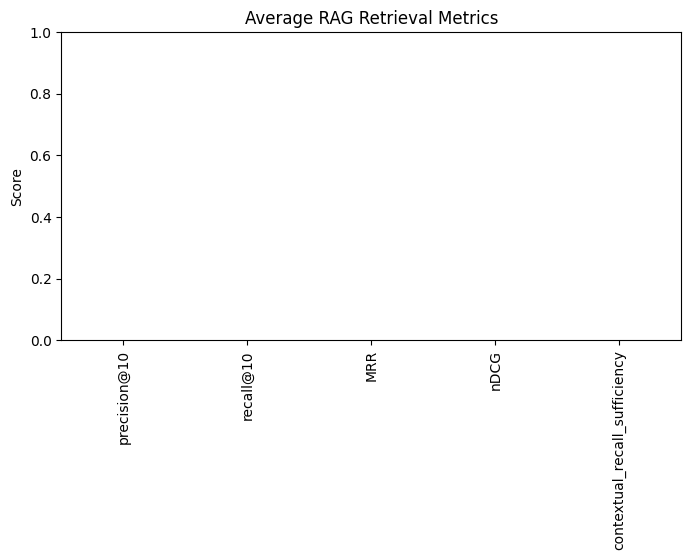

In [15]:
# Bar plot of average metrics
agg_metrics.plot(kind="bar", figsize=(8,4), ylim=(0,1), title="Average RAG Retrieval Metrics")
plt.ylabel("Score")
plt.show()

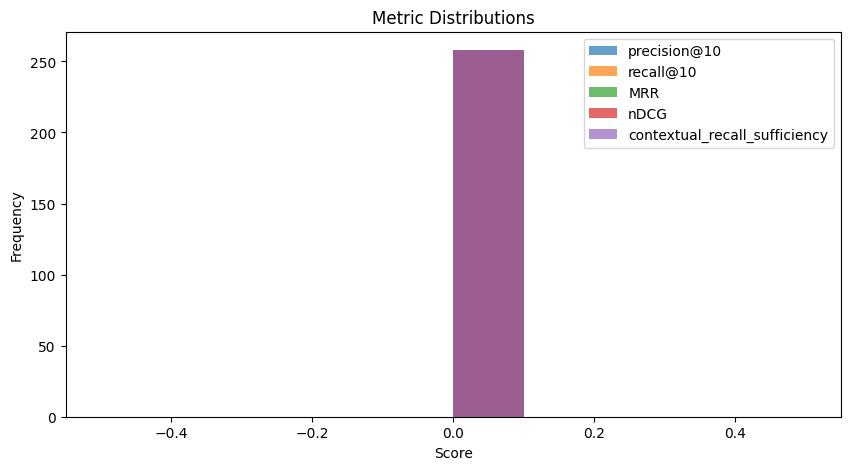

In [16]:
# Distribution Plots
metrics_df[[f"precision@{TOP_K}", f"recall@{TOP_K}", "MRR", "nDCG", "contextual_recall_sufficiency"]].plot.hist(alpha=0.7, bins=10, figsize=(10,5), title="Metric Distributions")
plt.xlabel("Score")
plt.show()

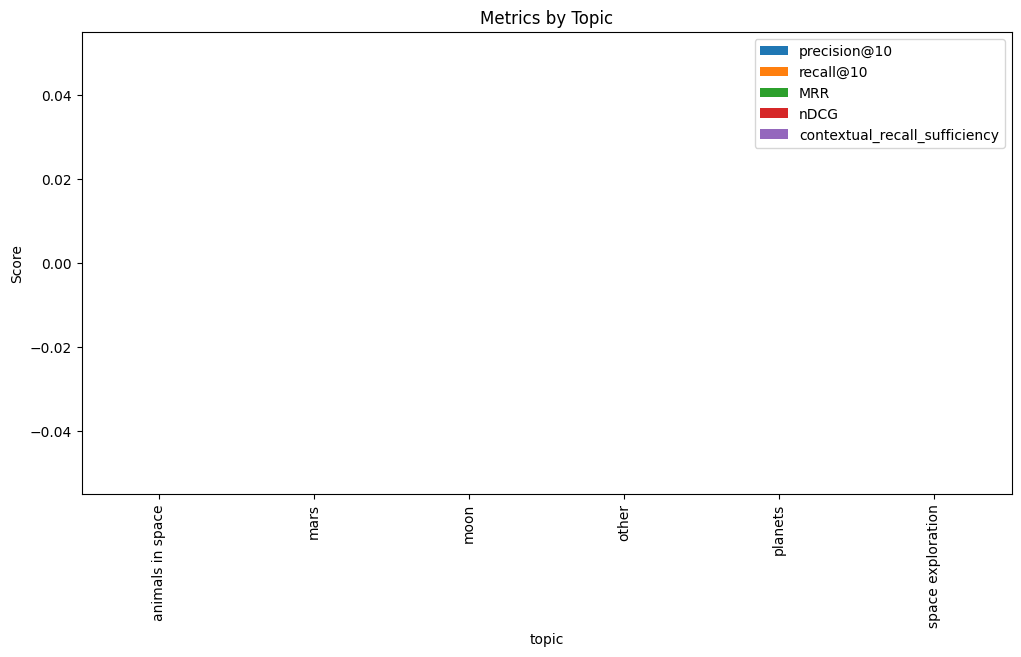

In [17]:
# Metrics by Topic or Level
if "topic" in ground_truth_df.columns:
    merged = pd.concat([metrics_df, ground_truth_df[["topic"]]], axis=1)
    topic_means = merged.groupby("topic").mean(numeric_only=True)
    topic_means.plot(kind="bar", figsize=(12,6), title="Metrics by Topic")
    plt.ylabel("Score")
    plt.show()

In [18]:
metrics_df.to_csv(f"../{METRICS_SUMMARY_FILE}", index=False)
print(f"Saved metrics summary to {METRICS_SUMMARY_FILE}")

Saved metrics summary to data/eval/metrics_summary.csv


In [20]:
# Show the first few queries for debugging
for g, r in zip(ground_truth, results):
    print("Query:", g.get("query"))
    print("Ground truth (ground_truth_chunks):", g.get("ground_truth_chunks"))
    print("Type of ground_truth_chunks:", type(g.get("ground_truth_chunks")))
    print("Retrieved (retrieved_chunks):", r.get("retrieved_chunks"))
    print("Type of retrieved_chunks:", type(r.get("retrieved_chunks")))
    if g.get("ground_truth_chunks") and r.get("retrieved_chunks"):
        print("Sample ground truth item type:", type(g.get("ground_truth_chunks")[0]))
        print("Sample retrieved item type:", type(r.get("retrieved_chunks")[0]))
    print("-" * 60)
    break  # Remove break to see more queries


Query: None
Ground truth (ground_truth_chunks): None
Type of ground_truth_chunks: <class 'NoneType'>
Retrieved (retrieved_chunks): None
Type of retrieved_chunks: <class 'NoneType'>
------------------------------------------------------------
